# ML(H)
## John Williamson 2019/2020

---

# Visualisation in machine learning

## Outline
In this lab we will explore how we can use visualisation to explore data before we begin training models. We will do this in the context of a challenge to classify audio data.

### Task
The task involves optimising the pre-processing of features for a simple classification problem, using visualisation (unsupervised learning) to help guide you in choosing good feature vector selection. The idea is to get *insight* into the data **using visualisation** to create effective machine learning models.

### Classifier
We will only use the most basic of classifiers in this example -- **k nearest neighbours** -- and focus on how to process the features to make this simple algorithm work as effectively as possible. Many modern approaches would use deep learning to learn an end-to-end classifier that infers appropriate feature extraction directly.

Everything to do the analysis and testing is provided for you. Your task is to modify the parameters that affect the creation of the feature vectors (see the green highlighted box below) and explore different visualisations to help identify a good feature transform.


In [1]:
from __future__ import print_function, division
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import audio_task
%matplotlib inline

## Motivation
This topic is essentially the operations behind the **Stane** project [Paper](http://www.dcs.gla.ac.uk/~rod/publications/MurWilHugQua08.pdf) [Video](http://www.dcs.gla.ac.uk/~rod/Videos/i_chi2.mov)


This used 3D printed textures on mobile devices. Scratching the fingernail across the surface generates distinctive sounds, which are propagated through the case and picked up by a piezo microphone. Different regions have different textures, and thus the area being rubbed can be determined by analysing the audio signal.

<img src="imgs/piezo.png" width="400px">
<img src="imgs/stane_real.png" width="400px">
<!-- <img src="imgs/shell.png" width="400px">
<img src="imgs/disc.png" width="400px"> -->



### Feature vectors
In almost all machine learning contexts, we predict outputs given a **fixed length** set of features; the input space a fixed dimension $d$. Each of those features is usually (but not always) continuous-valued.

Sometimes the data fall naturally into this space (e.g. classifying the iris type by 3 physical measurements). In cases such as in audio classification, though, we want to make predictions based on *time series*; a set of measurements of the same variable set made repeatedly over time.

#### Windowing
One general solution to this time series problem is to break a sequence up into a fixed length sequence of previous measurements. For example the measurements $[x_{t=t}, x_{t=t-1}, x_{t=t-2}, \dots, x_{t=t-d}]$ might make up the feature vector. This process is known as *windowing*, because we chop up the data into fixed length windows by "sliding" a time window along the data. **Consecutive (but possible discontiguous or overlapping) windows are almost universally used in audio contexts.**

<img src="imgs/contiguous_windows.png">
<img src="imgs/overlapping_windows.png">

These windows can overlap, which increases the size of the training set, but excessive overlapping can capture lots of redundant features examples. This can increase overfitting and training time without improving the classifier performance. Balancing the size of the windows (and thus the feature vector size $d$) and the amount of overlap is a matter of experimentation and domain knowledge.

-----------------

## Feature transforms

Often the "natural" raw form of the data can be difficult to classify. This might be because it has very high dimension, it is very noisy, or the classification boundary just isn't very compatible with your classifier (e.g. the class borders in the original space are highly-nonlinear and you are using a linear classifier). 

**Feature engineering** is the art of finding transforms of the raw data that increase classifier performance. These can often be simple, such as dropping some of the measurements entirely (under the assumption that they are irrelvant), or averaging measurements together (under the assumption that this reduces noise).

### Audio transforms
**Audio** data tends to be very high dimensional -- you might get 4000 to 44100 measurements for a single second of data.  A single audio sample has very little information indeed; it is the longer-term (millisecond to second) properties that have all the interesting information. 

So want transforms that pull out interesting features **over time**. The classical feature transform is the **Fourier transform**, which rewrites a signal varying over time as a sum of sinusoidal (periodic) components. This functions much like our ear works, splitting up audio in **frequency bands**, each of which has a **phase** and an **amplitude**. Many of these are already implemented in standard libraries, like the Fast Fourier Transform (fft) and the Discrete Cosine Transform (dct). We will use these in our classification problem.

# The challenge
<a id="challenge"></a>
You have to use visualisation strategies to choose a feature vector transform for a classifier that classifies the region of a device that is being touched based on the sound recorded from a piezo contact microphone. There are four possible touch regions and also a silence/handling noise class (class 0):

<img src="imgs/regions.png"> 

The data are all in the `data/` folder.

You have training data for these regions, `challenge_train_{01234}.wav`

See the code below which plots test datasets consisting of labeled mixtures of these classes alongside your predicted labels.  The code below loads the data from 4Khz 16 bit mono wavefiles into a collection of features vectors `X` and a corresponding set of labels `y`.  

### Feature selection
You can modify the feature selection properties set below to adjust the results. **The rest of the pipeline is fixed  -- you cannot modify the classifier itself in this exercise.**
<div class="alert alert-box alert-success">
    
This cell below is the only control you have over the performance of the classification. You will use the visualisation techniques to explore how these transforms change the data you get. NOTE: you may well not understand the meaning of the parameters. Use the visualisations to help guide you to a good choice.
</div>

In [2]:
######### PARAMETERS ##################
# You can change these values
# 1 sample = 1/4096 of a second
import numpy as np
import sklearn.datasets, sklearn.linear_model, sklearn.neighbors
import sklearn.manifold, sklearn.cluster
parameters = {
'size':4096, # how long each window is, in samples
'step':256, # how many samples to move forward in each window
'decimate':5, # how much reduction of the feature vector to perform; integer = 1,2,3,4,5...
'feature_range' :(0.0, 1.0), # what slice of the feature vectors to take (0.0, 1.0)=whole vector
# must be between 0.0 and 1.0 for the start and end 
'window_fn':"boxcar", # one of window_fns (below)
'feature_fn':"cepstrum" # one of feature_fns    
}
#####################################

# valid feature_fns: ['dct', 'fft', 'fft_phase', 'dct_phase', 'cepstrum', 'raw'])
# valid window_fns: ['hamming', 'hann', 'boxcar', 'blackmanharris']

Run the following cells to (re)load the data into a set of features and labels

In [3]:
X, y = audio_task.load_data(parameters)
print("X shape", X.shape, "y shape", y.shape)

Loading into 336 windows of length 4096
Loading into 807 windows of length 4096
Loading into 692 windows of length 4096
Loading into 985 windows of length 4096
Loading into 955 windows of length 4096
Using cepstrum transform and a boxcar window.
X shape (3775, 820) y shape (3775,)


In [4]:
# if you don't have UMAP installed, uncomment and run the line below (once only)
!pip install --no-cache --user umap-learn

## Visualisation

We can visualise these features. Experiment with using:
* PCA `sklearn.decomposition.pca`
* LLE `sklearn.manifold.LocallyLinearEmbedding`
* ISOMAP `sklearn.manifold.Isomap`
* tSNE `sklearn.manifold.TSNE`
* UMAP `umap`

You can use alternative visualisation methods if you wish. **You may need to subsample the features to visualise in reasonable time.**. For example, you can subsample to just every 10th feature vector using `X[::10, :]`

Use the visualisations to find a feature vector selection that you expect to perform well with a a kNN classifier. Use the visualisation to explore these transforms rather than trial and error with the classifier itself.

<div class="alert alert-box alert-success"> 

**Task**: iterate over visualisations and tweaks to the feature preprocessing to see if you can find a structure that separates classes well.
</div>

(-10.886262013382057,
 54.4852373102499,
 -0.32116167626205244,
 0.6672968804293111)

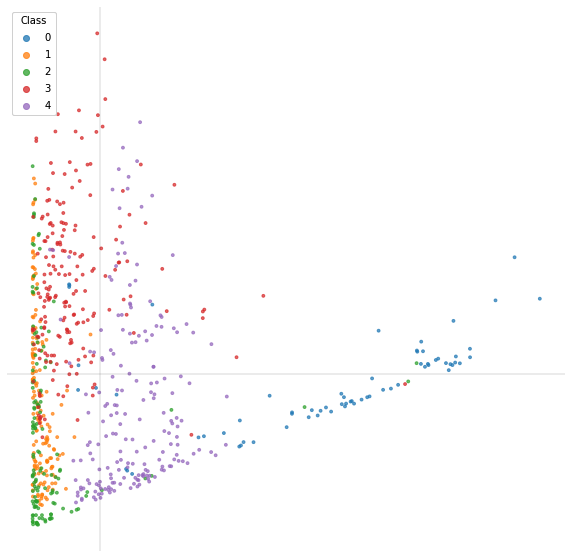

In [5]:
import numpy as np
import sklearn.datasets, sklearn.linear_model, sklearn.neighbors
import sklearn.manifold, sklearn.cluster
fig, ax = plt.subplots(figsize=(10, 10))

subsample = 5
PCA_x=sklearn.decomposition.PCA(n_components=2).fit_transform(X[::subsample, :])

# show a scatter plot of the first two dimensions
scatter = ax.scatter(
   PCA_x[:, 0],
    PCA_x[:, 1],
    c=y[::subsample],
    cmap="tab10",
    vmin=0,
    vmax=10,
    alpha=0.7,
    s=8,
)

legend1 = ax.legend(*scatter.legend_elements(num=4), loc="upper left", title="Class")
ax.add_artist(legend1)

ax.axhline(0, color="k", alpha=0.1)
ax.axvline(0, color="k", alpha=0.1)

ax.axis("off")

(-0.1237621186262156,
 0.014990494640678158,
 -0.1534020303830487,
 0.014468817517999381)

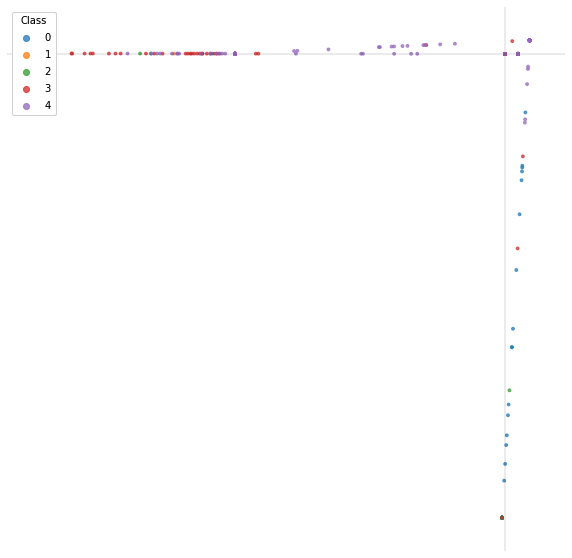

In [6]:
import numpy as np
import sklearn.datasets, sklearn.linear_model, sklearn.neighbors
import sklearn.manifold, sklearn.cluster
fig, ax = plt.subplots(figsize=(10, 10))
subsample = 5
LLE_x= sklearn.manifold.LocallyLinearEmbedding(n_components=2).fit_transform(X[::subsample, :])

# show a scatter plot of the first two dimensions
scatter = ax.scatter(
   LLE_x[:, 0],
    LLE_x[:, 1],
    c=y[::subsample],
    cmap="tab10",
    vmin=0,
    vmax=10,
    alpha=0.7,
    s=8,
)


legend1 = ax.legend(*scatter.legend_elements(num=4), loc="upper left", title="Class")
ax.add_artist(legend1)

ax.axhline(0, color="k", alpha=0.1)
ax.axvline(0, color="k", alpha=0.1)

ax.axis("off")

(-11.792214118606294,
 55.714387827766686,
 -1.8146827637419367,
 3.2302283849477798)

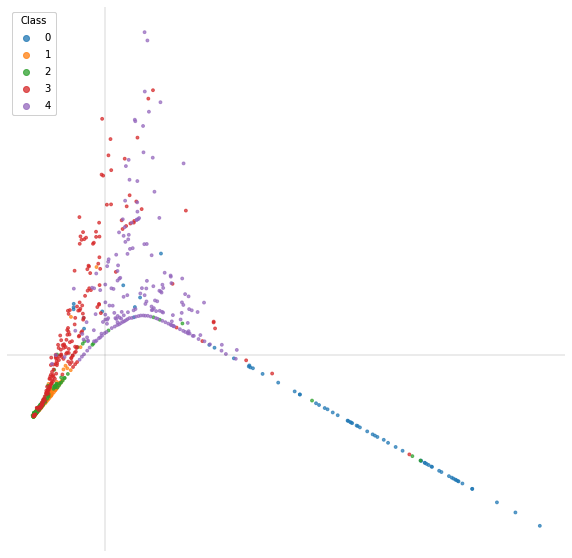

In [7]:
import numpy as np
import sklearn.datasets, sklearn.linear_model, sklearn.neighbors
import sklearn.manifold, sklearn.cluster
fig, ax = plt.subplots(figsize=(10, 10))


subsample = 5
ISO_x=sklearn.manifold.Isomap(n_neighbors=7).fit_transform((X[::subsample, :]))



# show a scatter plot of the first two dimensions
scatter = ax.scatter(
   ISO_x[:, 0],
    ISO_x[:, 1],
    c=y[::subsample],
    cmap="tab10",
    vmin=0,
    vmax=10,
    alpha=0.7,
    s=8,
)

legend1 = ax.legend(*scatter.legend_elements(num=4), loc="upper left", title="Class")
ax.add_artist(legend1)

ax.axhline(0, color="k", alpha=0.1)
ax.axvline(0, color="k", alpha=0.1)

ax.axis("off")


(-25.955107212135726,
 38.781782627174785,
 -47.58501647804732,
 35.00751518105025)

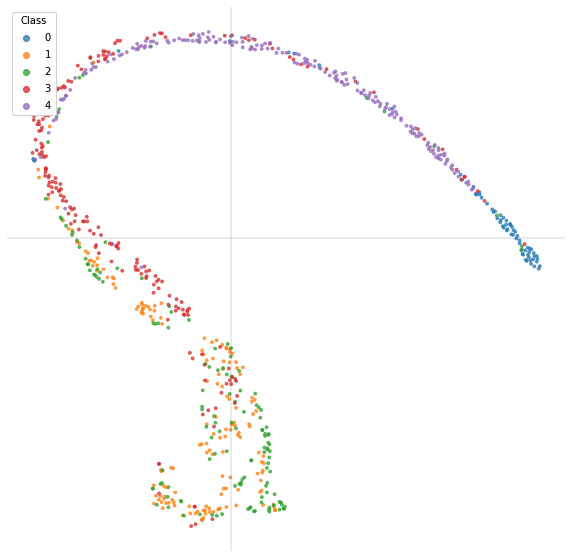

In [8]:
import numpy as np
import sklearn.datasets, sklearn.linear_model, sklearn.neighbors
import sklearn.manifold, sklearn.cluster

fig, ax = plt.subplots(figsize=(10, 10))

subsample = 5
TSNE_x= sklearn.manifold.TSNE().fit_transform(X[::subsample, :])




# show a scatter plot of the first two dimensions
scatter = ax.scatter(
  TSNE_x[:, 0],
    TSNE_x[:, 1],
    c=y[::subsample],
    cmap="tab10",
    vmin=0,
    vmax=10,
    alpha=0.7,
    s=8,
)


legend1 = ax.legend(*scatter.legend_elements(num=4), loc="upper left", title="Class")
ax.add_artist(legend1)

ax.axhline(0, color="k", alpha=0.1)
ax.axvline(0, color="k", alpha=0.1)

ax.axis("off")

(-18.048941230843, 9.459011650154524, -14.069097889409017, 13.573329342350908)

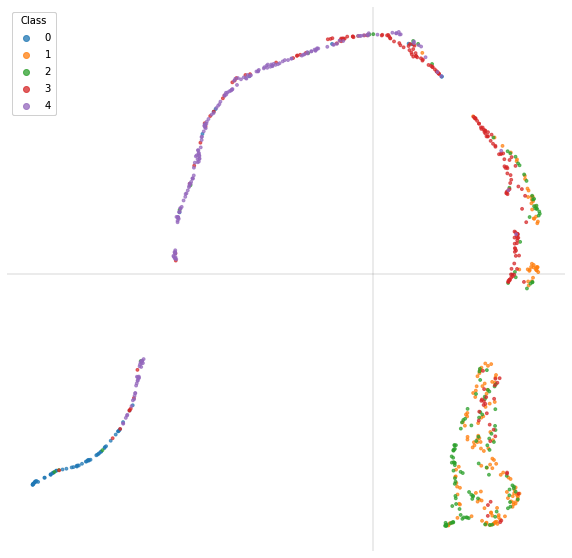

In [9]:
import numpy as np
import sklearn.datasets, sklearn.linear_model, sklearn.neighbors
import sklearn.manifold,umap, sklearn.cluster

fig, ax = plt.subplots(figsize=(10, 10))

subsample = 5
UMAP_x= umap.UMAP(min_dist=0.2).fit_transform(X[::subsample, :])




# show a scatter plot of the first two dimensions
scatter = ax.scatter(
 UMAP_x[:, 0],
   UMAP_x[:, 1],
    c=y[::subsample],
    cmap="tab10",
    vmin=0,
    vmax=10,
    alpha=0.7,
    s=8,
)

legend1 = ax.legend(*scatter.legend_elements(num=4), loc="upper left", title="Class")
ax.add_artist(legend1)

ax.axhline(0, color="k", alpha=0.1)
ax.axvline(0, color="k", alpha=0.1)

ax.axis("off")





In [10]:
# fit a classifier
classifier = audio_task.knn_fit(X, y)



### Visualising predictions 
You can preview your results with a separate (non-secret) test set which is provided. This will show you a visualisation of your classifier versus the ground truth. Each visualisation shows the true activity (below the axis) as coloured blocks and the predicted activity (from the classifier) as coloured blocks above the axis.

In the case of perfect classification, the blocks above and below the line will be exactly the same. In practice, there will always be significant noise.

Testing with data/challenge_test_0
Loading into 292 windows of length 4096
Predicting...
Prediction accuracy 0.611
Confusion matrix
[[423   0  51  17   0]
 [ 47  91  87  89  14]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [ 16   0   8  53  87]]

Testing with data/challenge_test_1
Loading into 460 windows of length 4096
Predicting...
Prediction accuracy 0.223
Confusion matrix
[[ 55  53  30 173 147]
 [  0   0   0   0   0]
 [  0 139  92  57  17]
 [  0 212 170  74   0]
 [ 68   0   0 117 119]]

Testing with data/challenge_test_2
Loading into 200 windows of length 4096
Predicting...
Prediction accuracy 0.829
Confusion matrix
[[  0   0   0   0   0]
 [ 11  46   8  10  40]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [ 42   0   0   7 525]]

Testing with data/challenge_test_3
Loading into 428 windows of length 4096
Predicting...
Prediction accuracy 0.773
Confusion matrix
[[460   2   0  12   0]
 [  0 316  23 124  10]
 [  0   0   0   0   0]
 [  0  59  92 322   0]
 [  0   0   0   0   0]]

Test

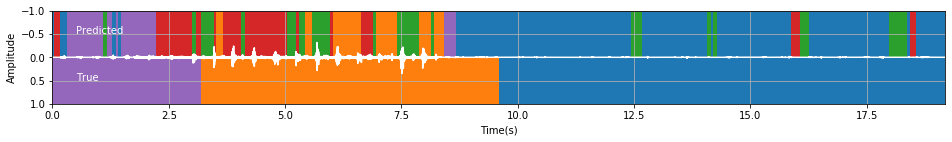

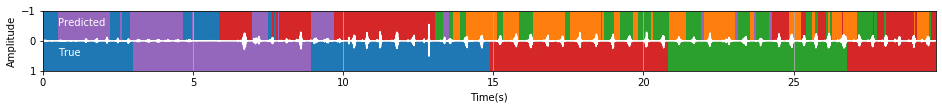

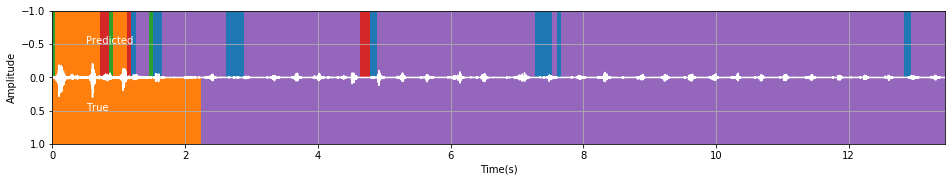

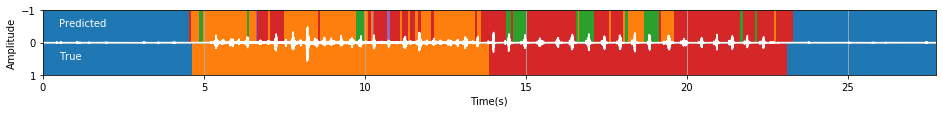

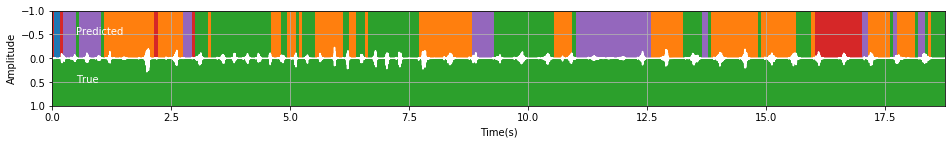

In [11]:
## Example usage -- show results for all of the test cases
for i in range(5):
    audio_task.plot_test(classifier, parameters, f"data/challenge_test_{i}")


### Final test function
There is a test function `challenge_evaluate_performance(classifier_fn)`. This gives you your total current score. You don't have access to the internals of this function. See below for how to use it.
The test takes some time to run; so you must be parsimonious with your calls to it.

In [12]:
## Shows how to evaluate your performance
audio_task.run_secret_test(classifier, parameters)

Loading into 762 windows of length 4096
Predicting...


C:\Users\Prince\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Prince\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Loading into 229 windows of length 4096
Predicting...
Loading into 130 windows of length 4096
Predicting...


C:\Users\Prince\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Prince\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Loading into 679 windows of length 4096
Predicting...


C:\Users\Prince\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Prince\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Prince\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Prince\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Loading into 16 windows of length 4096
Predicting...
Loading into 265 windows of length 4096
Predicting...
Loading into 182 windows of length 4096
Predicting...
Loading into 574 windows of length 4096
Predicting...


C:\Users\Prince\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


*** Total score: 83.20 ***


C:\Users\Prince\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [13]:
from sklearn.naive_bayes import GaussianNB 

model = GaussianNB()                      
model.fit(X, y)   
y_model = model.predict(X)
from sklearn.metrics import accuracy_score

accuracy_score(y, y_model)

0.8039735099337748

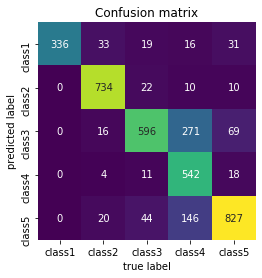

In [14]:
from sklearn.metrics import confusion_matrix

import seaborn as sns
matrix = confusion_matrix(y, y_model)
sns.heatmap(matrix.T, square=True, annot=True, fmt='d', cbar=False, cmap='viridis',
            xticklabels=['class1', 'class2', 'class3','class4','class5'], yticklabels=['class1', 'class2', 'class3','class4','class5'])

plt.title('Confusion matrix')
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.show()